In [199]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
from scripts.mri.logger import Logger
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Callable, Union, Dict, Any

from utils.makepath import makepath as mkp
from config.config_loader import load_config
from data.mri.data_loader import get_data_loader
from scripts.mri.epoch import perform_epoch
# from utils.data_util import DataUtil as GeneralDataUtil
# from encoding_objects.cart_2d_enc_obj import Cart2DEncObj
# from utils.metrics import ImageMetricsEvaluator
from utils.visualize import make_colorbar

In [201]:
from sithom.plot import (
    plot_defaults,
    label_subplots,
    get_dim,
    set_dim,
    PALETTE,
    STD_CLR_LIST,
    CAM_BLUE,
    BRICK_RED,
    OX_BLUE,
)

# # Use Latex (optional)
uses_latex = True
# uses_latex = False
plot_defaults(use_tex=uses_latex)

In [202]:
# device = "cpu"
device = "cuda"

In [203]:
root_dir = mkp("..", "..")

In [204]:
# data_config, u_tv_net, u_tgv_net = get_data_config_and_models(
#     device=device, root_dir=root_dir)

In [205]:
# print(f"U-TV sigma: {u_tv_net.sigma}")
# print(f"U-TV tau: {u_tv_net.tau}")

In [206]:
# print(f"U-TGV sigma: {u_tgv_net.sigma}")
# print(f"U-TGV tau: {u_tgv_net.tau}")

In [207]:
# test_dataset = get_dataset(
#     action="test",
#     data_config=data_config,
#     device=device,
#     acceleration_factor_R=8,
#     gaussian_noise_standard_deviation_sigma=0.05
# )

In [208]:
# enc_obj = Cart2DEncObj()

In [209]:
# metrics_evaluator = ImageMetricsEvaluator(
#     complex_to_real_conversion="abs", device=device)

In [210]:
out_dir = mkp(".", str(device))
os.makedirs(out_dir, exist_ok=True)
print(f"Output directory: {out_dir}")

Output directory: cuda


In [211]:
x_clip_range = (0, 0.5)
kdata_clip_range = (0, 0.2)
lambda1_v_clip_range = (0, 0.05)
lambda0_w_clip_range = (0, 1)
lambda_ratio_clip_range = (0, 10)

In [212]:
fraction_of_line_width = 0.5
height_to_width_ratio = 0.3

In [213]:
def save_colorbar(
        min_val: Union[int, float],
        max_val: Union[int, float],
        cmap: Union[str, Colormap],
        out_path: Union[str, Path],
        # fraction_of_line_width: float,
):
    fig = plt.figure()
    set_dim(
        fig,
        fraction_of_line_width=fraction_of_line_width,   # Adjust font size
        ratio=height_to_width_ratio   # Height/Width ratio
    )
    print(f"Saving colorbar to {str(out_path)}")
    make_colorbar(
        min_val=min_val, max_val=max_val,
        leq_min=True, geq_max=True,
        cmap=cmap, out_path=out_path)

Saving colorbar to cuda/colorbar_x.pdf
Saving colorbar to cuda/colorbar_kdata.pdf
Saving colorbar to cuda/colorbar_lambda1_v.pdf
Saving colorbar to cuda/colorbar_lambda0_w.pdf
Saving colorbar to cuda/colorbar_lambda_ratio.pdf


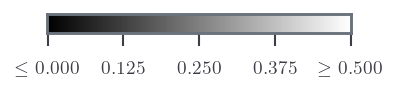

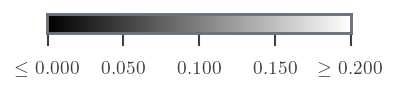

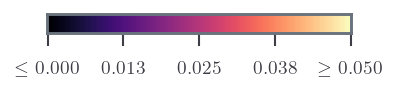

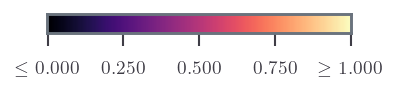

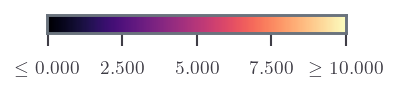

In [214]:
save_colorbar(*x_clip_range, cmap="gray", out_path=mkp(out_dir, "colorbar_x.pdf"))
save_colorbar(*kdata_clip_range, cmap="gray", out_path=mkp(out_dir, "colorbar_kdata.pdf"))
save_colorbar(*lambda1_v_clip_range, cmap="magma", out_path=mkp(out_dir, "colorbar_lambda1_v.pdf"))
save_colorbar(*lambda0_w_clip_range, cmap="magma", out_path=mkp(out_dir, "colorbar_lambda0_w.pdf"))
save_colorbar(*lambda_ratio_clip_range, cmap="magma", out_path=mkp(out_dir, "colorbar_lambda_ratio.pdf"))


In [215]:
# test_image_saver = TestImageSaver(
#     acc_factor_R=8,
#     gaussian_noise_sigma=0.05,
#     complex_to_real_conversion="abs",
#     out_dir=out_dir,
#     num_iters=256,
#     fraction_of_line_width=0.6,
#     height_to_width_ratio=0.3,

#     root_dir=root_dir,
#     x_clip_range=x_clip_range,
#     kdata_clip_range=kdata_clip_range,
#     lambda1_v_clip_range=lambda1_v_clip_range,
#     lambda0_w_clip_range=lambda0_w_clip_range,
#     lambda_ratio_clip_range=lambda_ratio_clip_range,
#     device=device,
#     tqdm_progress_bar=tqdm,
# )

In [216]:
# plt.figure(figsize=(24, 20))
# test_image_saver.test_sample_and_save_images(
#     sample_idx=0
# )
# # test_sample_and_save_images(
# #     saves=False,
# #     sample_idx=0,
# #     dataset=test_dataset,
# #     enc_obj=enc_obj,
# #     u_tv_net=u_tv_net,
# #     u_tgv_net=u_tgv_net,
# #     num_iters=256,

# #     out_dir=out_dir,
# #     metrics_evaluator=metrics_evaluator,
# #     x_clip_range=x_clip_range,
# #     kdata_clip_range=kdata_clip_range,
# #     lambda1_v_clip_range=lambda1_v_clip_range,
# #     lambda0_w_clip_range=lambda0_w_clip_range,
# #     lambda_ratio_clip_range=lambda_ratio_clip_range,
# #     fraction_of_line_width=0.33,
# #     tqdm_progress_bar=tqdm
# # )
# plt.show()


In [217]:
def get_zero_filled(
    kdata,
    kmask,
    x,
    csmap
):
    return x, None

In [218]:
def test_and_save_results(
        config: Dict[str, Any],
        reconstructor: Union[torch.nn.Module, Callable],
        general_action: str,
        acceleration_factor_R: int,
        sigma: float,
        force_overwrite: bool = False
):
    print(f"Testing with {general_action} data, R = {acceleration_factor_R}, sigma = {sigma}")

    test_data_loader = get_data_loader(
        config=config,
        action=general_action,
        dataset_type="preprocessed",
        device=device,
        acceleration_factor_R=acceleration_factor_R,
        gaussian_noise_standard_deviation_sigma=sigma
    )

    specific_action = f"{general_action}-R_{acceleration_factor_R}-sigma_{sigma:.2f}".replace(".", "_")

    test_logger = Logger(
        action=specific_action,
        config=config,
        force_overwrite=force_overwrite
    )
    test_logger.init_metrics_logging_options()
    # Set the intermediate log frequency to 1
    test_logger.log_freq_by_iter["intermediate"] = 1

    avg_metrics = perform_epoch(
        data_loader=test_data_loader,
        pdhg_net=reconstructor,
        is_training=False,
        logger=test_logger,
        # learning_rate_scheduler=None,
        # optimizer=None,
        tqdm_progress_bar=tqdm
    )
    return avg_metrics

In [219]:
zero_filled_config = load_config(
    config_choice=mkp(root_dir, "config", "zero_filled_config.yaml"),
    is_training=False,
    root_dir=root_dir
)

Config loaded from file ../../config/zero_filled_config.yaml


In [220]:
# acceleration_factor_R = 4
# sigma = 0.15
# general_action = "test"
# # action = "val"
# force_overwrite = False
# # force_overwrite = True

for acceleration_factor_R in []:
    for sigma in []:
        test_and_save_results(
            config=zero_filled_config,
            reconstructor=get_zero_filled,
            general_action="test",
            acceleration_factor_R=acceleration_factor_R,
            sigma=sigma,
            # force_overwrite=False
            force_overwrite=True
        )